<a href="https://colab.research.google.com/github/JoshWeissman/QuarterbackAnalysis/blob/main/QuarterbackAnalysisDraft1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Name:          Joshua Weissman
Date:          12/15/2024
Course:        CIS 2450
Professor:     Zachary Ives
```

# **CIS 2450 FInal Project - Tom Brady is not the GOAT**

# Part 1: Introduction

There is a common misconception in sports: that rings equals greatness.  And while for many sports this is arguably true, the more players on your team the lower your personal impact on the game.  For example, in sports like tennis, golf and chess, winning tournaments is a direct reflection of ones ability.  On the other hand, in sports like baseball, cricket, and... dare I say... football, it is much more difficult to measure an individuals impact on the game, even if they are playing in the most important position, the quarterback.  But what makes this "quarterback" so special?  When a team is on offense, the quarterback has the ball in his hand almost every single play.  The quarterback is leading his team, calling the plays and excecuting them.  But are team wins a quartreback stat and, moreover, a direct reflection of the quarterback's ability?  Let's think about it.  If a quarterback has better recievers then he will have more open recievers to pass to on a given play.  If a quarterback has a better running back then the defense will be forced to expect a run, leaving the quarterback with more room to operate.  A better offensive line means more time for the quarterback to survey the field.  A better coach means better plays for the quarterback to excecute.  I think you get the point.  But despite all this, one quarterback has become the consensses GOAT (Greatest of All Time).  This quarterback's name is Tom Brady.

Thus, this project sets out to explore two questions:
1. Who is the Greatest NFL Quarterback of all time?
2. Should wins be a Quarterback statistic, or in other words, what is the measureable impact of a Quarterback on a team's win?

We will answer those questions by doing a deep dive into the stats accross all 32 NFL teams during the Tom Brady era, 2000 to 2016.  We will assess the abilities of four main Quarterbacks who are by concensess concidered to be the best during that era of foorball.  Those Quarterbacks are Tom Brady, Aaron Rodgers, Peyton Manning and Drew Brees.  Additionally, we will construct models to predict the outcomes of games based off of player stats using the QB data and ignoring, thus assessing how important QB stats are to predicting the outcome of a game.

# Part 2: Data Loading & Preprocessing

For this step, we sought to import the relevant libraries for all stages of our report (pre-processing, exploratory data analysis, and model selection). These imports primarily span fundamental libraries such as pandas, matplotlib, numpy, and sklearn.

In [1]:
# Install TensorFlow
!pip install tensorflow

# General imports
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# TensorFlow
import tensorflow as tf
from tensorflow.keras import models, layers

# Additional imports
import kagglehub

## 2.1 Loading NFL statistics data from Kaggle

#### 2.1.1 Downloading data from Kaggle

We are downloading data from https://www.kaggle.com/datasets/kendallgillies/nflstatistics which contains player performance information from every NFL game between 1970 and 2016.

In [2]:
# Download data from Kaggle
path = kagglehub.dataset_download("kendallgillies/nflstatistics")

#### 2.1.2 Downloading data from Kaggle

We are saving each needed csv file we downloaded from kaggle in a python dataframe.  Note that we don't need every file offered in the kaggle project, so we commented out the ones that we don't need.  We want only statistics of the quarterbacks, running backs, wide recievers and kickers.  (Note that we also want the stats of the defense, but each of the game logs include the final score, so we will use that to figure out how many points the defense gave up.)

In [3]:
# CSV file names
csv_files = [
    # "Basic_Stats.csv",
    # "Career_Stats_Defensive.csv",
    "Career_Stats_Field_Goal_Kickers.csv",
    # "Career_Stats_Fumbles.csv",
    # "Career_Stats_Kick_Return.csv",
    # "Career_Stats_Kickoff.csv",
    # "Career_Stats_Offensive_Line.csv",
    "Career_Stats_Passing.csv",
    # "Career_Stats_Punt_Return.csv",
    # "Career_Stats_Punting.csv",
    "Career_Stats_Receiving.csv",
    "Career_Stats_Rushing.csv",
    # "Game_Logs_Defensive_Lineman.csv",
    "Game_Logs_Kickers.csv",
    # "Game_Logs_Offensive_Line.csv",
    # "Game_Logs_Punters.csv",
    "Game_Logs_Quarterback.csv",
    "Game_Logs_Runningback.csv",
    "Game_Logs_Wide_Receiver_and_Tight_End.csv",
]

# Dictionary to store DataFrames for NFL players
nfl_dfs = {}

# Load each CSV file into a DataFrame and put it into the NFL players dfs
for file_name in csv_files:
    nfl_dfs[file_name.replace('.csv', '')] = pd.read_csv(f'{path}/{file_name}')

print(list(nfl_dfs.keys()))

['Career_Stats_Field_Goal_Kickers', 'Career_Stats_Passing', 'Career_Stats_Receiving', 'Career_Stats_Rushing', 'Game_Logs_Kickers', 'Game_Logs_Quarterback', 'Game_Logs_Runningback', 'Game_Logs_Wide_Receiver_and_Tight_End']


## 2.2 Processing player performance data

#### 2.2.1 Quarterback df setup

Let's start by selecting our Quarterback game log.

In [4]:
# Selecting QB df
qb_df = nfl_dfs['Game_Logs_Quarterback']
qb_df.head()

,Player Id,Name,Position,Year,Season,Week,Game Date,Home or Away,Opponent,Outcome,...,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost
0,jaredzabransky/2495791,"Zabransky, Jared",NaN,2007,Preseason,1,08/11,Home,CHI,L,...,--,--,--,0.0,--,--,--,--,--,--
1,jaredzabransky/2495791,"Zabransky, Jared",NaN,2007,Preseason,2,08/18,Away,ARI,W,...,0,0,0,46.9,--,--,--,--,--,--
2,jaredzabransky/2495791,"Zabransky, Jared",NaN,2007,Preseason,3,08/25,Home,DAL,W,...,--,--,--,0.0,--,--,--,--,--,--
3,jaredzabransky/2495791,"Zabransky, Jared",NaN,2007,Preseason,4,08/30,Away,TB,L,...,1,2,13,50.8,2,17,8.5,0,--,--
4,billdemory/2512778,"Demory, Bill",NaN,1974,Regular Season,1,09/15,Away,KC,L,...,--,--,--,0.0,--,--,--,--,--,--


Now lets select the columns we want.  A quarterback's rushing ability is certainly an important part of their game.  However, for the sake of the project, we will concentrate on their throwing statistics.  Specifically, we care about their name (of course) as well as the year, week, date of the game, final score and outcome (win vs. loss).  Performance-wise, we care about Passes Completed, Passes Attempted, Completion Percentage, Passing Yards, Passing Yards Per Attempt, TD Passes, Ints and Passer Rating.

In [5]:
# Selecting desired columns
qb_df = qb_df[['Name', 'Year', 'Week', 'Game Date', 'Outcome', 'Score', 'Passes Completed', 'Passes Attempted', 'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt', 'TD Passes', 'Ints', 'Passer Rating']]
qb_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,object
Outcome,object
Score,object
Passes Completed,object
Passes Attempted,object
Completion Percentage,object
Passing Yards,object


Let's now make sure that all of our data is as the type we would want it to be.  We want most of our data to be in integer or float form since that will make it much easier for us to work with for training our models later.

In [6]:
# Make a copy of qb_df to avoid SettingWithCopyWarning
qb_df = qb_df.copy()

# Format strings as desired
qb_df['Year'] = qb_df['Year'].astype(int)
qb_df['Week'] = qb_df['Week'].astype(int)
qb_df['Game Date'] = pd.to_datetime(qb_df['Year'].astype(str) + '-' + qb_df['Game Date'].str.replace('/', '-'), format='%Y-%m-%d')
qb_df['Outcome'] = qb_df['Outcome'].astype('category')
qb_df['Team Score'] = qb_df['Score'].str.split(' to ').str[0].astype(int)
qb_df['Opponent Score'] = qb_df['Score'].str.split(' to ').str[1].astype(int)
qb_df.drop('Score', axis=1, inplace=True)
qb_df['Passes Completed'] = qb_df['Passes Completed'].str.replace(',', '').replace('--', '0').astype(int)
qb_df['Passes Attempted'] = qb_df['Passes Attempted'].str.replace(',', '').replace('--', '0').astype(int)
qb_df['Completion Percentage'] = qb_df['Completion Percentage'].str.replace(',', '').replace('--', '0').astype(float)
qb_df['Passing Yards'] = qb_df['Passing Yards'].str.replace(',', '').replace('--', '0').astype(int)
qb_df['Passing Yards Per Attempt'] = qb_df['Passing Yards Per Attempt'].str.replace(',', '').replace('--', '0').astype(float)
qb_df['TD Passes'] = qb_df['TD Passes'].str.replace(',', '').replace('--', '0').astype(int)
qb_df['Ints'] = qb_df['Ints'].str.replace(',', '').replace('--', '0').astype(int)
qb_df['Passer Rating'] = qb_df['Passer Rating'].astype(float)

# Print
qb_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,datetime64[ns]
Outcome,category
Passes Completed,int64
Passes Attempted,int64
Completion Percentage,float64
Passing Yards,int64
Passing Yards Per Attempt,float64


There are a few important things to notice here.  First of all, the season stretch all the way back to 1970 (long before the QB dominant era), so we for the sake of analyzing QB play in the "Tom Brady Era" we will ignore all data before the year 2000.

In [7]:
# Only look at years after 2000 (inclusive)
qb_df = qb_df[qb_df['Year'] >= 2000]

Additionally, we can see that many of the games are in the preseason (where teams aren't starting their star players), so this is likely not representitive of a usual football game.  Therefore, we will remove all preseason games.

In [8]:
# Remove preseason games
qb_df = qb_df[qb_df['Week'] != 'Preseason']

Let's also ignore all games where the quarterback didn't play or barely played.  We will measure this by making sure that the QB threw at least 10 passes.

In [9]:
# Remove all games where the quarterback didn't play or barely played
qb_df = qb_df[qb_df['Passes Attempted'] >= 10]
qb_df.head()

,Name,Year,Week,Game Date,Outcome,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Ints,Passer Rating,Team Score,Opponent Score
3,"Zabransky, Jared",2007,4,2007-08-30,L,12,22,54.5,117,5.3,0,1,50.8,24,31
30,"Savage, Tom",2016,1,2016-08-14,W,14,24,58.3,168,7.0,2,0,107.6,24,13
31,"Savage, Tom",2016,2,2016-08-20,W,7,12,58.3,75,6.3,0,0,76.7,16,9
32,"Savage, Tom",2016,3,2016-08-28,W,4,11,36.4,75,6.8,1,0,91.1,34,24
33,"Savage, Tom",2016,4,2016-09-01,W,12,18,66.7,119,6.6,1,0,103.7,28,17


The only column we are missing that will be important is what team the player played for in that season.  Luckily, we have a database for career stats that includes what player played for what team in what year.  We will use that database to do a join here, so we know what team a player played on in a given year.  We will also drop any rows where we can't tell what team a player played for.  If we can't tell, they were probably irrelevant anyway.

In [10]:
# Merge the team of that player by their name and year
qb_df = qb_df.merge(nfl_dfs['Career_Stats_Passing'][['Name', 'Year', 'Team']], on=['Name', 'Year'], how='left')

# Drop null rows (ie: rows where we don't know what team a player played for)
qb_df.dropna(inplace=True)

# Display new df
qb_df.head()

,Name,Year,Week,Game Date,Outcome,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Ints,Passer Rating,Team Score,Opponent Score,Team
1,"Savage, Tom",2016,1,2016-08-14,W,14,24,58.3,168,7.0,2,0,107.6,24,13,Houston Texans
2,"Savage, Tom",2016,2,2016-08-20,W,7,12,58.3,75,6.3,0,0,76.7,16,9,Houston Texans
3,"Savage, Tom",2016,3,2016-08-28,W,4,11,36.4,75,6.8,1,0,91.1,34,24,Houston Texans
4,"Savage, Tom",2016,4,2016-09-01,W,12,18,66.7,119,6.6,1,0,103.7,28,17,Houston Texans
5,"Savage, Tom",2016,15,2016-12-18,W,23,36,63.9,260,7.2,0,0,85.4,21,20,Houston Texans


Now lets also get QB stats by season instead of just by game.

In [11]:
# Function to properly aggrigate qb statistics
def aggregate_qb_stats(group):
    return pd.Series({
        'Games Played': len(group),
        'Total Passes Completed': group['Passes Completed'].sum(),
        'Total Passes Attempted': group['Passes Attempted'].sum(),
        'Avg Completion Percentage': group['Completion Percentage'].mean(),
        'Total Passing Yards': group['Passing Yards'].sum(),
        'Avg Passing Yards Per Attempt': group['Passing Yards Per Attempt'].mean(),
        'Total TD Passes': group['TD Passes'].sum(),
        'Total Interceptions': group['Ints'].sum(),
        'Avg Passer Rating': group['Passer Rating'].mean(),
        'Total Team Score': group['Team Score'].sum(),
        'Total Opponent Score': group['Opponent Score'].sum(),
        'Team': group['Team'].iloc[0]
    })

# Call function on qb seasons
qb_season_df = qb_df.groupby(['Name', 'Year']).apply(aggregate_qb_stats).reset_index()
qb_season_df.head()

<ipython-input-11-29787a054f96>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qb_season_df = qb_df.groupby(['Name', 'Year']).apply(aggregate_qb_stats).reset_index()


,Name,Year,Games Played,Total Passes Completed,Total Passes Attempted,Avg Completion Percentage,Total Passing Yards,Avg Passing Yards Per Attempt,Total TD Passes,Total Interceptions,Avg Passer Rating,Total Team Score,Total Opponent Score,Team
0,"Aikman, Troy",2000,8,150,249,60.112500,1573,6.600000,6,13,70.100000,147,167,Dallas Cowboys
1,"Anderson, Derek",2006,5,77,139,54.560000,889,6.320000,6,9,65.980000,69,124,Cleveland Browns
2,"Anderson, Derek",2007,18,315,569,54.772222,3966,7.083333,29,20,81.105556,448,436,Cleveland Browns
3,"Anderson, Derek",2008,11,146,293,49.354545,1635,5.372727,9,8,64.300000,188,223,Cleveland Browns
4,"Anderson, Derek",2009,10,96,206,47.390000,1095,5.670000,3,11,50.040000,148,201,Cleveland Browns


#### 2.2.2 Running Back df setup

Let's start by selecting our Running back game log.

In [12]:
# Selecting RB df
rb_df = nfl_dfs['Game_Logs_Runningback']
rb_df.head()

,Player Id,Name,Position,Year,Season,Week,Game Date,Home or Away,Opponent,Outcome,...,Yards Per Carry,Longest Rushing Run,Rushing TDs,Receptions,Receiving Yards,Yards Per Reception,Longest Reception,Receiving TDs,Fumbles,Fumbles Lost
0,bobbyfowler/2514295,"Fowler, Bobby",NaN,1985,Regular Season,7,10/20,Away,ATL,L,...,--,--,--,--,--,--,--,--,--,--
1,bobbyfowler/2514295,"Fowler, Bobby",NaN,1985,Regular Season,8,10/27,Home,NYG,L,...,--,--,--,--,--,--,--,--,--,--
2,bobbyfowler/2514295,"Fowler, Bobby",NaN,1985,Regular Season,9,11/03,Away,RAM,L,...,--,--,--,3,27,9.0,10,0,--,--
3,bobbyfowler/2514295,"Fowler, Bobby",NaN,1985,Regular Season,10,11/10,Home,SEA,L,...,--,--,--,--,--,--,--,--,--,--
4,bobbyfowler/2514295,"Fowler, Bobby",NaN,1985,Regular Season,11,11/17,Away,GB,L,...,1.0,1,0,--,--,--,--,--,--,--


Now lets select the columns we want.  A running back's recieving ability is certainly an important part of their game.  However, for the sake of the project, we will concentrate on their rushing statistics.  Specifically, we care about their name (of course) as well as the year, week, date of the game, final score and outcome (win vs. loss).  Performance-wise, we care about Rushing Attempts, Rushing Yards, Yards Per Carry and Rushing TDs.

In [13]:
# Selecting desired columns
rb_df = rb_df[['Name', 'Year', 'Week', 'Game Date', 'Outcome', 'Score', 'Rushing Attempts', 'Rushing Yards', 'Yards Per Carry', 'Rushing TDs']]
rb_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,object
Outcome,object
Score,object
Rushing Attempts,object
Rushing Yards,object
Yards Per Carry,object
Rushing TDs,object


Let's now make sure that all of our data is as the type we would want it to be.

In [14]:
# Make a copy of qb_df to avoid SettingWithCopyWarning
rb_df = rb_df.copy()

# Format strings as desiredrb_df['Year'] = rb_df['Year'].astype(int)
rb_df['Week'] = rb_df['Week'].astype(int)
rb_df['Game Date'] = pd.to_datetime(rb_df['Year'].astype(str) + '-' + rb_df['Game Date'].str.replace('/', '-'), format='%Y-%m-%d')
rb_df['Outcome'] = rb_df['Outcome'].astype('category')
rb_df['Team Score'] = rb_df['Score'].str.split(' to ').str[0].astype(int)
rb_df['Opponent Score'] = rb_df['Score'].str.split(' to ').str[1].astype(int)
rb_df.drop('Score', axis=1, inplace=True)
rb_df['Rushing Attempts'] = rb_df['Rushing Attempts'].str.replace(',', '').replace('--', '0').astype(int)
rb_df['Rushing Yards'] = rb_df['Rushing Yards'].str.replace(',', '').replace('--', '0').astype(int)
rb_df['Yards Per Carry'] = rb_df['Yards Per Carry'].str.replace(',', '').replace('--', '0').astype(float)
rb_df['Rushing TDs'] = rb_df['Rushing TDs'].str.replace(',', '').replace('--', '0').astype(int)

# Print
rb_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,datetime64[ns]
Outcome,category
Rushing Attempts,int64
Rushing Yards,int64
Yards Per Carry,float64
Rushing TDs,int64
Team Score,int64


There are a few important things to notice here.  First of all, the season stretch all the way back to 1970 (long before the QB dominant era), so we for the sake of analyzing QB play in the "Tom Brady Era" we will ignore all data before the year 2000.

In [15]:
# Only look at years after 2000 (inclusive)
rb_df = rb_df[rb_df['Year'] >= 2000]

Additionally, we can see that many of the games are in the preseason (where teams aren't starting their star players), so this is likely not representitive of a usual football game.  Therefore, we will remove all preseason games.

In [16]:
# Remove preseason games
rb_df = rb_df[rb_df['Week'] != 'Preseason']

The only column we are missing that will be important is what team the player played for in that season.  Luckily, we have a database for career stats that includes what player played for what team in what year.  We will use that database to do a join here, so we know what team a player played on in a given year.  We will also drop any rows where we can't tell what team a player played for.  If we can't tell, they were probably irrelevant anyway.

In [17]:
# Display new df
rb_df = rb_df.merge(nfl_dfs['Career_Stats_Rushing'][['Name', 'Year', 'Team']], on=['Name', 'Year'], how='left')

# Drop null rows (ie: rows where we don't know what team a player played for)
rb_df.dropna(inplace=True)

# Display new df
rb_df.head()

,Name,Year,Week,Game Date,Outcome,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Team Score,Opponent Score,Team
0,"Johnson, Quinn",2013,1,2013-08-08,L,0,0,0.0,0,21,22,Tennessee Titans
1,"Johnson, Quinn",2013,2,2013-08-17,L,0,0,0.0,0,19,27,Tennessee Titans
2,"Johnson, Quinn",2013,3,2013-08-24,W,0,0,0.0,0,27,16,Tennessee Titans
3,"Johnson, Quinn",2013,4,2013-08-29,L,0,0,0.0,0,23,24,Tennessee Titans
4,"Johnson, Quinn",2013,14,2013-12-08,L,0,0,0.0,0,28,51,Tennessee Titans


Now lets stop focusing on individul players for rushing and get the team statistics for each game.

In [18]:
# Function to properly aggrigate RB statistics per team per week
def aggregate_team_rb_stats(group):
    return pd.Series({
        'Total Rushing Attempts': group['Rushing Attempts'].sum(),
        'Total Rushing Yards': group['Rushing Yards'].sum(),
        'Avg Yards Per Carry': group['Rushing Yards'].sum() / group['Rushing Attempts'].sum() if group['Rushing Attempts'].sum() > 0 else 0,
        'Total Rushing TDs': group['Rushing TDs'].sum(),
        'Team Score': group['Team Score'].iloc[0],
        'Opponent Score': group['Opponent Score'].iloc[0],
        'Outcome': group['Outcome'].iloc[0],
        'Game Date': group['Game Date'].iloc[0],
        'Players Involved': ', '.join(group['Name'].unique())
    })

# Call function on RB weeks for a team
rb_team_df = rb_df.groupby(['Year', 'Week', 'Team']).apply(aggregate_team_rb_stats).reset_index()
rb_team_df.head()

<ipython-input-18-33fb9927fd50>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rb_team_df = rb_df.groupby(['Year', 'Week', 'Team']).apply(aggregate_team_rb_stats).reset_index()


,Year,Week,Team,Total Rushing Attempts,Total Rushing Yards,Avg Yards Per Carry,Total Rushing TDs,Team Score,Opponent Score,Outcome,Game Date,Players Involved
0,2000,1,Arizona Cardinals,4,9,2.250000,0,16,21,L,2000-09-03,"Pittman, Michael, Makovicka, Joel"
1,2000,1,Atlanta Falcons,27,82,3.037037,0,36,28,W,2000-09-03,"Rivers, Ron, Christian, Bob, Anderson, Jamal, ..."
2,2000,1,Baltimore Ravens,5,16,3.200000,0,16,0,W,2000-09-03,"Lewis, Jamal, Gash, Sam"
3,2000,1,Buffalo Bills,0,0,0.000000,0,16,13,W,2000-09-03,"Linton, Jonathan"
4,2000,1,Carolina Panthers,0,0,0.000000,0,17,20,L,2000-09-03,"Floyd, William"


Now lets also get team rushing stats by season instead of just by game.

In [19]:
# Function to properly aggrigate RB statistics
def aggregate_rb_stats(group):
    return pd.Series({
        'Total Rushing Attempts': group['Rushing Attempts'].sum(),
        'Total Rushing Yards': group['Rushing Yards'].sum(),
        'Avg Yards Per Carry': group['Rushing Yards'].sum() / group['Rushing Attempts'].sum(),
        'Total Rushing TDs': group['Rushing TDs'].sum(),
        'Total Team Score': group['Team Score'].sum(),
        'Total Opponent Score': group['Opponent Score'].sum(),
        'Outcome': group['Outcome'].iloc[0],
        'Game Date': group['Game Date'].iloc[0],
        'Players Involved': ', '.join(group['Name'].unique())
    })

# Call function on RB seasons
rb_team_season_df = rb_df.groupby(['Team', 'Year']).apply(aggregate_rb_stats).reset_index()
rb_team_season_df.head()

<ipython-input-19-6197c90565c0>:6: RuntimeWarning: invalid value encountered in scalar divide
  'Avg Yards Per Carry': group['Rushing Yards'].sum() / group['Rushing Attempts'].sum(),
<ipython-input-19-6197c90565c0>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rb_team_season_df = rb_df.groupby(['Team', 'Year']).apply(aggregate_rb_stats).reset_index()


,Team,Year,Total Rushing Attempts,Total Rushing Yards,Avg Yards Per Carry,Total Rushing TDs,Total Team Score,Total Opponent Score,Outcome,Game Date,Players Involved
0,Arizona Cardinals,2000,187,727,3.887701,4,420,886,L,2000-09-03,"Pittman, Michael, Makovicka, Joel"
1,Arizona Cardinals,2001,242,865,3.574380,5,573,648,L,2001-09-30,"Pittman, Michael, Makovicka, Joel"
2,Arizona Cardinals,2002,52,173,3.326923,1,624,1048,W,2002-08-10,"Scobey, Josh, Anderson, Damien, Makovicka, Joel"
3,Arizona Cardinals,2003,18,68,3.777778,0,450,904,L,2003-09-07,"Scobey, Josh, Anderson, Damien"
4,Arizona Cardinals,2004,91,374,4.109890,1,568,644,L,2004-09-12,"Scobey, Josh, Anderson, Damien, Hambrick, Troy"


#### 2.2.3 Receiver df setup

Let's start by selecting our reciever game log.  (Note that wide recievers and tight ends are both concidered recievers) but we will refer to them all as wide recievers for the rest of the project because there is no decernable difference in their responsibilities that we care about.

In [20]:
# Selecting WR df
wr_df = nfl_dfs['Game_Logs_Wide_Receiver_and_Tight_End']
wr_df.head()

,Player Id,Name,Position,Year,Season,Week,Game Date,Home or Away,Opponent,Outcome,...,Yards Per Reception,Longest Reception,Receiving TDs,Rushing Attempts,Rushing Yards,Yards Per Carry,Longest Rushing Run,Rushing TDs,Fumbles,Fumbles Lost
0,floydraglin/2523695,"Raglin, Floyd",NaN,1987,Regular Season,3,10/04,Away,SEA,L,...,--,--,--,--,--,--,--,--,--,--
1,floydraglin/2523695,"Raglin, Floyd",NaN,1987,Regular Season,4,10/11,Home,KC,W,...,--,--,--,--,--,--,--,--,--,--
2,joeadams/2532782,"Adams, Joe",NaN,2014,Preseason,1,08/09,Away,ARI,L,...,--,--,--,--,--,--,--,--,1,0
3,joeadams/2532782,"Adams, Joe",NaN,2014,Preseason,2,08/16,Home,ATL,W,...,--,--,0,--,--,--,--,--,--,--
4,joeadams/2532782,"Adams, Joe",NaN,2014,Preseason,3,08/23,Away,DEN,W,...,--,--,--,--,--,--,--,--,--,--


Now lets select the columns we want.  A receivers rushing ability is certainly an important part of their game.  However, for the sake of the project, we will concentrate on their receiving statistics.  Specifically, we care about their name (of course) as well as the year, week, date of the game, final score and outcome (win vs. loss).  Performance-wise, we care about Receptions, Receiving Yards, Yards Per Reception, Longest Reception and Receiving TDs.

In [21]:
# Selecting desired columns
wr_df = wr_df[['Name', 'Year', 'Week', 'Game Date', 'Outcome', 'Score', 'Receptions', 'Receiving Yards', 'Yards Per Reception', 'Receiving TDs']]
wr_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,object
Outcome,object
Score,object
Receptions,object
Receiving Yards,object
Yards Per Reception,object
Receiving TDs,object


Let's now make sure that all of our data is as the type we would want it to be.

In [22]:
# Make a copy of qb_df to avoid SettingWithCopyWarning
wr_df = wr_df.copy()

# Format strings as desiredwr_df['Year'] = wr_df['Year'].astype(int)
wr_df['Week'] = wr_df['Week'].astype(int)
wr_df['Game Date'] = pd.to_datetime(wr_df['Year'].astype(str) + '-' + wr_df['Game Date'].str.replace('/', '-'), format='%Y-%m-%d')
wr_df['Outcome'] = wr_df['Outcome'].astype('category')
wr_df['Team Score'] = wr_df['Score'].str.split(' to ').str[0].astype(int)
wr_df['Opponent Score'] = wr_df['Score'].str.split(' to ').str[1].astype(int)
wr_df.drop('Score', axis=1, inplace=True)
wr_df['Receptions'] = wr_df['Receptions'].str.replace(',', '').replace('--', '0').astype(int)
wr_df['Receiving Yards'] = wr_df['Receiving Yards'].str.replace(',', '').replace('--', '0').astype(int)
wr_df['Yards Per Reception'] = wr_df['Yards Per Reception'].str.replace(',', '').replace('--', '0').astype(float)
wr_df['Receiving TDs'] = wr_df['Receiving TDs'].str.replace(',', '').replace('--', '0').astype(int)

# Print
rb_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,datetime64[ns]
Outcome,category
Rushing Attempts,int64
Rushing Yards,int64
Yards Per Carry,float64
Rushing TDs,int64
Team Score,int64


There are a few important things to notice here.  First of all, the season stretch all the way back to 1970 (long before the QB dominant era), so we for the sake of analyzing QB play in the "Tom Brady Era" we will ignore all data before the year 2000.

In [23]:
# Remove all games where the quarterback didn't play or barely played
wr_df = wr_df[wr_df['Year'] >= 2000]

Additionally, we can see that many of the games are in the preseason (where teams aren't starting their star players), so this is likely not representitive of a usual football game.  Therefore, we will remove all preseason games.

In [24]:
# Remove preseason games
wr_df = wr_df[wr_df['Week'] != 'Preseason']

The only column we are missing that will be important is what team the player played for in that season.  Luckily, we have a database for career stats that includes what player played for what team in what year.  We will use that database to do a join here, so we know what team a player played on in a given year.  We will also drop any rows where we can't tell what team a player played for.  If we can't tell, they were probably irrelevant anyway.

In [25]:
# Merge the team of that player by their name and year
wr_df = wr_df.merge(nfl_dfs['Career_Stats_Rushing'][['Name', 'Year', 'Team']], on=['Name', 'Year'], how='left')

# Drop null rows (ie: rows where we don't know what team a player played for)
wr_df.dropna(inplace=True)

# Display new df
wr_df.head()

,Name,Year,Week,Game Date,Outcome,Receptions,Receiving Yards,Yards Per Reception,Receiving TDs,Team Score,Opponent Score,Team
5,"Adams, Joe",2012,1,2012-08-11,L,0,0,0.0,0,13,26,Carolina Panthers
6,"Adams, Joe",2012,2,2012-08-17,W,0,0,0.0,0,23,17,Carolina Panthers
7,"Adams, Joe",2012,3,2012-08-26,W,0,0,0.0,0,17,12,Carolina Panthers
8,"Adams, Joe",2012,4,2012-08-30,L,0,0,0.0,0,16,17,Carolina Panthers
9,"Adams, Joe",2012,1,2012-09-09,L,0,0,0.0,0,10,16,Carolina Panthers


Now lets stop focusing on individul players for rushing and get the team statistics for each game.

In [26]:
# Function to properly aggrigate WR statistics per team per week
def aggregate_team_wr_stats(group):
    return pd.Series({
        'Total Receptions': group['Receptions'].sum(),
        'Total Receiving Yards': group['Receiving Yards'].sum(),
        'Avg Yards Per Reception': group['Receiving Yards'].sum() / group['Receptions'].sum() if group['Receptions'].sum() > 0 else 0,
        'Total Receiving TDs': group['Receiving TDs'].sum(),
        'Team Score': group['Team Score'].iloc[0],
        'Opponent Score': group['Opponent Score'].iloc[0],
        'Outcome': group['Outcome'].iloc[0],
        'Game Date': group['Game Date'].iloc[0],
        'Players Involved': ', '.join(group['Name'].unique())
    })

# Call function on WR for teams each week
wr_team_df = wr_df.groupby(['Year', 'Week', 'Team']).apply(aggregate_team_wr_stats).reset_index()
wr_team_df.head()

<ipython-input-26-b6233fd8af7b>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wr_team_df = wr_df.groupby(['Year', 'Week', 'Team']).apply(aggregate_team_wr_stats).reset_index()


,Year,Week,Team,Total Receptions,Total Receiving Yards,Avg Yards Per Reception,Total Receiving TDs,Team Score,Opponent Score,Outcome,Game Date,Players Involved
0,2000,1,Arizona Cardinals,6,91,15.166667,0,16,21,L,2000-09-03,"Jenkins, MarTay, Sanders, Frank, Gedney, Chris"
1,2000,1,Atlanta Falcons,10,220,22.000000,2,36,28,W,2000-09-03,"Mathis, Terance, Jefferson, Shawn"
2,2000,1,Baltimore Ravens,11,152,13.818182,1,16,0,W,2000-09-03,"Davis, Billy, Johnson, Pat, Ismail, Qadry, Tay..."
3,2000,1,Carolina Panthers,0,0,0.000000,0,17,20,L,2000-09-03,"Hankton, Karl, Bates, Michael"
4,2000,1,Chicago Bears,10,77,7.700000,0,27,30,L,2000-09-03,"Engram, Bobby, Kennison, Eddie, Bates, D'Wayne"


Now lets also get team rushing stats by season instead of just by game.

In [27]:
# Function to properly aggrigate WR statistics for each season
def aggregate_wr_stats(group):
    return pd.Series({
        'Total Receptions': group['Receptions'].sum(),
        'Total Receiving Yards': group['Receiving Yards'].sum(),
        'Avg Yards Per Reception': group['Receiving Yards'].sum() / group['Receptions'].sum(),
        'Total Receiving TDs': group['Receiving TDs'].sum(),
        'Total Team Score': group['Team Score'].sum(),
        'Total Opponent Score': group['Opponent Score'].sum(),
        'Outcome': group['Outcome'].iloc[0],
        'Game Date': group['Game Date'].iloc[0],
        'Players Involved': ', '.join(group['Name'].unique())
    })

# Call function on WR seasons
wr_team_season_df = wr_df.groupby(['Team', 'Year']).apply(aggregate_wr_stats).reset_index()
wr_team_season_df.head()

<ipython-input-27-ead20618a93f>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wr_team_season_df = wr_df.groupby(['Team', 'Year']).apply(aggregate_wr_stats).reset_index()


,Team,Year,Total Receptions,Total Receiving Yards,Avg Yards Per Reception,Total Receiving TDs,Total Team Score,Total Opponent Score,Outcome,Game Date,Players Involved
0,Arizona Cardinals,2000,81,1043,12.876543,6,640,1362,L,2000-09-03,"Jenkins, MarTay, Sanders, Frank, Gedney, Chris..."
1,Arizona Cardinals,2001,73,1136,15.561644,5,711,791,L,2001-09-23,"Jenkins, MarTay, Sanders, Frank, Gilmore, Bryan"
2,Arizona Cardinals,2002,88,1139,12.943182,7,1146,1400,W,2002-08-10,"Jenkins, MarTay, Sanders, Frank, Gilmore, Brya..."
3,Arizona Cardinals,2003,155,2053,13.245161,11,1009,1993,L,2003-09-07,"Foster, Larry, Boldin, Anquan, Johnson, Bryant..."
4,Arizona Cardinals,2004,163,1940,11.901840,10,852,966,L,2004-09-12,"Fitzgerald, Larry, Boldin, Anquan, Johnson, Br..."


#### 2.2.4 Kicker df setup

Let's start by selecting our Kicker game log.

In [28]:
# Selecting Kicker df
k_df = nfl_dfs['Game_Logs_Kickers']
k_df.head()

,Player Id,Name,Position,Year,Season,Week,Game Date,Home or Away,Opponent,Outcome,...,FG Percentage,Extra Points Made,Extra Points Attempted,Percentage of Extra Points Made,Extra Points Blocked,Kickoffs,Yards Per Kickoff,Touchbacks,Kickoffs Returned,Average Returned Yards
0,fabrizioscaccia/2508100,"Scaccia, Fabrizio",NaN,2011,Preseason,1,08/12,Away,NO,L,...,--,--,--,--,--,2,43.0,1,0,--
1,fabrizioscaccia/2508100,"Scaccia, Fabrizio",NaN,2011,Preseason,2,08/20,Home,OAK,W,...,--,--,--,--,--,4,66.5,1,3,31.0
2,jeffhall/2500970,"Hall, Jeff",NaN,2000,Regular Season,11,11/12,Away,NYG,W,...,50.0,4,4,100.0,0,7,60.1,0,7,24.7
3,jeffhall/2500970,"Hall, Jeff",NaN,2000,Regular Season,12,11/20,Home,WAS,L,...,100.0,2,2,100.0,0,5,58.0,0,5,21.2
4,jeffhall/2500970,"Hall, Jeff",NaN,2000,Regular Season,13,11/26,Home,NO,L,...,100.0,3,3,100.0,0,4,65.3,0,4,26.0


Now lets select the columns we want.  A receivers rushing ability is certainly an important part of their game.  However, for the sake of the project, we will concentrate on their receiving statistics.  Specifically, we care about their name (of course) as well as the year, week, date of the game, final score and outcome (win vs. loss).  Performance-wise, we care about FGs Attempted, FGs Made, FG Percentage, Extra Points Made, Extra Points Attempted and Percentage of Extra Points Made.

In [29]:
# Selecting desired columns
k_df = k_df[['Name', 'Year', 'Week', 'Game Date', 'Outcome', 'Score', 'FGs Attempted', 'FGs Made', 'FG Percentage', 'Extra Points Made', 'Extra Points Attempted', 'Percentage of Extra Points Made']]
k_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,object
Outcome,object
Score,object
FGs Attempted,object
FGs Made,object
FG Percentage,object
Extra Points Made,object


Let's now make sure that all of our data is as the type we would want it to be.

In [30]:
# Make a copy of qb_df to avoid SettingWithCopyWarning
k_df = k_df.copy()

# Format strings as desiredk_df['Year'] = k_df['Year'].astype(int)
k_df['Week'] = k_df['Week'].astype(int)
k_df['Game Date'] = pd.to_datetime(k_df['Year'].astype(str) + '-' + k_df['Game Date'].str.replace('/', '-'), format='%Y-%m-%d')
k_df['Outcome'] = k_df['Outcome'].astype('category')
k_df['Team Score'] = k_df['Score'].str.split(' to ').str[0].astype(int)
k_df['Opponent Score'] = k_df['Score'].str.split(' to ').str[1].astype(int)
k_df.drop('Score', axis=1, inplace=True)
k_df['FGs Attempted'] = k_df['FGs Attempted'].str.replace(',', '').replace('--', '0').astype(int)
k_df['FGs Made'] = k_df['FGs Made'].str.replace(',', '').replace('--', '0').astype(int)
k_df['FG Percentage'] = k_df['FG Percentage'].str.replace(',', '').replace('--', '0').astype(float)
k_df['Extra Points Made'] = k_df['Extra Points Made'].str.replace(',', '').replace('--', '0').astype(int)
k_df['Extra Points Attempted'] = k_df['Extra Points Attempted'].str.replace(',', '').replace('--', '0').astype(int)
k_df['Percentage of Extra Points Made'] = k_df['Percentage of Extra Points Made'].str.replace(',', '').replace('--', '0').astype(float)

# Print
rb_df.dtypes

,0
Name,object
Year,int64
Week,int64
Game Date,datetime64[ns]
Outcome,category
Rushing Attempts,int64
Rushing Yards,int64
Yards Per Carry,float64
Rushing TDs,int64
Team Score,int64


There are a few important things to notice here.  First of all, the season stretch all the way back to 1970 (long before the QB dominant era), so we for the sake of analyzing QB play in the "Tom Brady Era" we will ignore all data before the year 2000.

In [31]:
# Only look at years after 2000 (inclusive)
k_df = k_df[k_df['Year'] >= 2000]

Additionally, we can see that many of the games are in the preseason (where teams aren't starting their star players), so this is likely not representitive of a usual football game.  Therefore, we will remove all preseason games.

In [32]:
# Remove preseason games
k_df = k_df[k_df['Week'] != 'Preseason']

The only column we are missing that will be important is what team the player played for in that season.  Luckily, we have a database for career stats that includes what player played for what team in what year.  We will use that database to do a join here, so we know what team a player played on in a given year.  We will also drop any rows where we can't tell what team a player played for.  If we can't tell, they were probably irrelevant anyway.

In [33]:
# Merge the team of that player by their name and year
k_df = k_df.merge(nfl_dfs['Career_Stats_Rushing'][['Name', 'Year', 'Team']], on=['Name', 'Year'], how='left')

# Drop null rows (ie: rows where we don't know what team a player played for)
k_df.dropna(inplace=True)

# Display new df
k_df.head()

,Name,Year,Week,Game Date,Outcome,FGs Attempted,FGs Made,FG Percentage,Extra Points Made,Extra Points Attempted,Percentage of Extra Points Made,Team Score,Opponent Score,Team
342,"Carney, John",2010,4,2010-10-03,W,3,3,100.0,1,1,100.0,16,14,New Orleans Saints
343,"Carney, John",2010,5,2010-10-10,L,3,2,66.7,2,2,100.0,20,30,New Orleans Saints
344,"Carney, John",2009,2,2009-08-22,W,0,0,0.0,3,3,100.0,38,14,New Orleans Saints
345,"Carney, John",2009,3,2009-08-29,W,1,1,100.0,4,4,100.0,45,7,New Orleans Saints
346,"Carney, John",2009,4,2009-09-03,L,1,0,0.0,1,1,100.0,7,10,New Orleans Saints


Now lets also get team rushing stats by season instead of just by game.

In [34]:
# Function to properly aggrigate kicker statistics
def aggregate_kicker_stats(group):
    return pd.Series({
        'Total FGs Attempted': group['FGs Attempted'].sum(),
        'Total FGs Made': group['FGs Made'].sum(),
        'Avg FG Percentage': group['FG Percentage'].mean(),
        'Total Extra Points Made': group['Extra Points Made'].sum(),
        'Total Extra Points Attempted': group['Extra Points Attempted'].sum(),
        'Avg Percentage of Extra Points Made': group['Percentage of Extra Points Made'].mean(),
        'Total Team Score': group['Team Score'].sum(),
        'Total Opponent Score': group['Opponent Score'].sum(),
        'Outcome': group['Outcome'].iloc[0],
        'Game Date': group['Game Date'].iloc[0],
        'Players Involved': ', '.join(group['Name'].unique())
    })

# Call function on kicker seasons
k_team_season_df = k_df.groupby(['Team', 'Year']).apply(aggregate_kicker_stats).reset_index()
k_team_season_df.head()

<ipython-input-34-602aa4ed7db6>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  k_team_season_df = k_df.groupby(['Team', 'Year']).apply(aggregate_kicker_stats).reset_index()


,Team,Year,Total FGs Attempted,Total FGs Made,Avg FG Percentage,Total Extra Points Made,Total Extra Points Attempted,Avg Percentage of Extra Points Made,Total Team Score,Total Opponent Score,Outcome,Game Date,Players Involved
0,Arizona Cardinals,2003,12,9,69.042857,8,8,57.142857,95,217,L,2003-11-16,"Rackers, Neil"
1,Arizona Cardinals,2004,29,22,71.881250,28,28,68.750000,284,322,L,2004-09-12,"Rackers, Neil"
2,Arizona Cardinals,2005,45,43,89.217647,22,22,82.352941,328,410,L,2005-09-11,"Rackers, Neil"
3,Arizona Cardinals,2006,42,33,71.755000,37,37,90.000000,384,477,W,2006-08-12,"Rackers, Neil"
4,Arizona Cardinals,2007,38,28,68.335000,55,56,92.500000,481,513,L,2007-08-11,"Rackers, Neil"


# Part 3: Exploratory Data Analysis

## 3.1 Quarterback stats for potential GOATs

There are many quarterbacks that could be concidered the greatest of all time.  However, there are a only a few that are uninimously recognized as contenders from the Tom Brady era of football.  Those QBs are **Tom Brady**, **Aarond Rodgers**, **Peyton Manning** and **Drew Brees**.  In this section, we will compare some of the statistics from their career to see by counting stats, who is the best quarterback.

In [35]:
# List of great QBs that we will compare
great_qbs = ["Brady, Tom", "Rodgers, Aaron", "Manning, Peyton", "Brees, Drew"]

# Select import quarterbacks seasons
great_qbs_df = qb_season_df[qb_season_df['Name'].isin(great_qbs)]

#### 3.1.1 Passing Yards

We will start by looking at the passing yards for each season for each quarterback.  This is the easiest stastic to analyze since a quarterback is clearly doing better if they are throwing for more yards of the season.  As we go further into our exploratory data analysis, we will look at more specific stats that give us more specific insights.

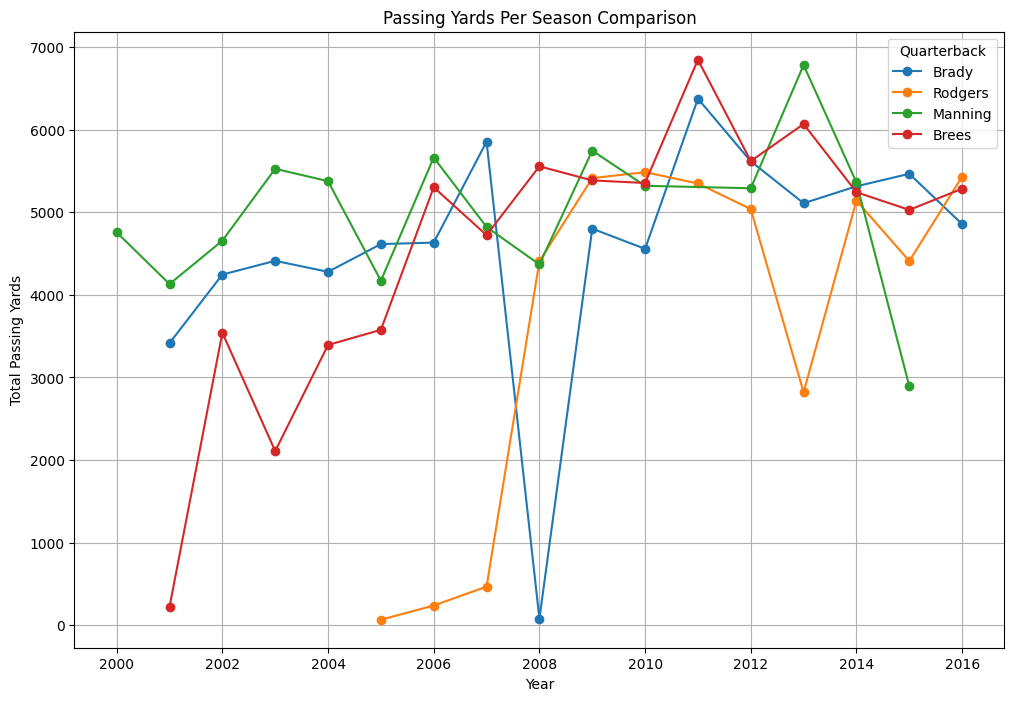

In [36]:
# Plot the passing yards per season for each of the great QBS
plt.figure(figsize=(12, 8))
for qb in great_qbs:
    qb_stats = great_qbs_df[great_qbs_df['Name'] == qb]
    plt.plot(qb_stats['Year'], qb_stats['Total Passing Yards'], marker='o', label=qb.split(',')[0])

# Add titles and extra information and show
plt.legend(title="Quarterback")
plt.title("Passing Yards Per Season Comparison")
plt.ylabel("Total Passing Yards")
plt.xlabel("Year")
plt.grid()
plt.show()

**Takeaways:** We see in this plot that Brees and manning consistently through of the most yards, while Brady and rodgers through for fewer yards each season.  We can see that the first few years of Brees' and Rodgers' carrees, they few for surprisingly few yards.  Additionally, each player has a couple seasons where they have a huge dip in yards thrown for.  This is because they might have only played a few games that season due to injury.  Thus , this likely isn't the best statistic to represent QB ability.

#### 3.1.2 Passing Yards Per Game

For this graph, we will look at the yards a QB threw in each game they played.  For all of the later statistics, we will, likewise, only look at per-game statistics to mitigate the fact the quaterbacks may have missed games due to injury or illness.

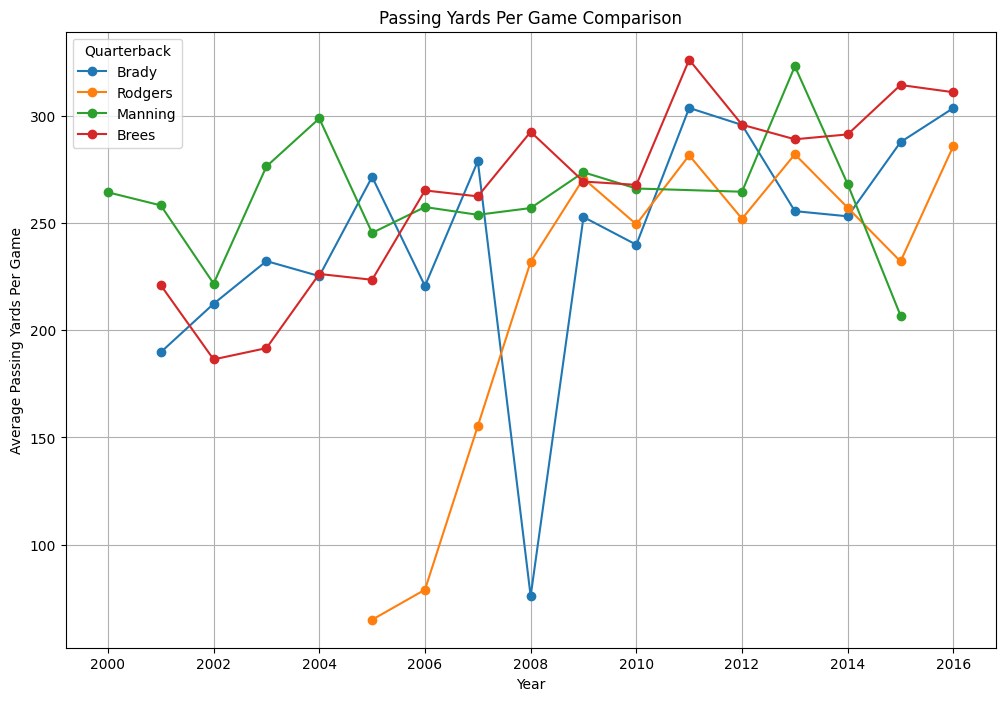

In [37]:
# Plot the passing yards per game each season for each of the great QBS
plt.figure(figsize=(12, 8))
for qb in great_qbs:
    qb_stats = great_qbs_df[great_qbs_df['Name'] == qb]
    qb_stats = qb_stats[qb_stats['Games Played'] > 0]
    plt.plot(qb_stats['Year'], qb_stats['Total Passing Yards'] / qb_stats['Games Played'],
             marker='o', label=qb.split(',')[0])

# Add titles and extra information and show
plt.legend(title="Quarterback")
plt.title("Passing Yards Per Game Comparison")
plt.ylabel("Average Passing Yards Per Game")
plt.xlabel("Year")
plt.grid()
plt.show()


**Takeaways:** You'll notice that in this graph, the discrpencies between different players is much smaller.  Passing Yards per game puts all four players much closer together.  There are still the random outliers, but this happened because the players got hurt in the first game of the season or because they were playing as a backup for a different quarterback.  The main takeaway from the graph above is that Brees seems to consistently be on top for most throwing yards each game of the season on average.  Then is goes Manning,  Brady and Rodgers is last.  This suggests that Brees might be the best quarterback.  However, this doesn't take into account how many times he gets to throw the ball.  In fact, the Packers (Rodgers' team) was famous for running often which would mean that Rodgers had fewer oppertunities to throw.

#### 3.1.3 Passing Yards Per Attempts

Thus, we will look at how many yards each quarterback got per throwing attempt on average per season.  This should give insight into how efficient each quarterback was.

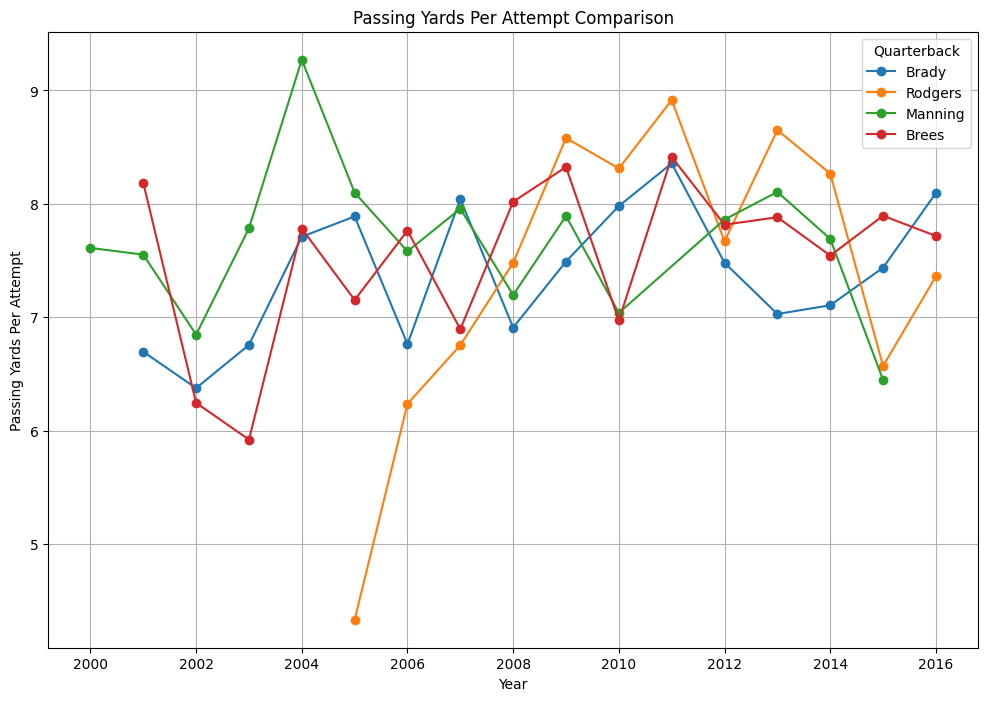

In [38]:
# Plot the passing yards per attempt per game for each season for each of the great QBS
plt.figure(figsize=(12, 8))
for qb in great_qbs:
    qb_stats = great_qbs_df[great_qbs_df['Name'] == qb]
    qb_stats = qb_stats[qb_stats['Total Passes Attempted'] > 0]
    plt.plot(qb_stats['Year'], qb_stats['Total Passing Yards'] / qb_stats['Total Passes Attempted'], marker='o', label=qb.split(',')[0])

# Add titles and extra information and show
plt.legend(title="Quarterback")
plt.title("Passing Yards Per Attempt Comparison")
plt.ylabel("Passing Yards Per Attempt")
plt.xlabel("Year")
plt.grid()
plt.show()

**Takeaways:** By this metric, we see that Aaron Rodgers through for more yards with every pass over the course of most of his career.  (Note that in his early career, he played very few plays which is why the graph is skewed down for his first couple years).  This means that for every pass these quarerbacks threw throughout their careers, Rodgers throws counted for more yards.  On the other hand, Tom Brady consistently through short, easy completions which aren't as valuble to a team.  Being able to get more yards for each time you try to throw is arguably much more valuble then total yards.  Thus we see that in this case, Rodgers climbs to the top of this list.  Perhaps, he didn't have to throw the ball as often because teams were more afraid of him throwing the ball, so his team was able to call a running play.

#### 3.1.4 Touchdowns

Touchdowns are a completely different kind of QB metric that represent if the quarterback was able to throw the ball into tight spaces in the endzone which are usually heavily contested.

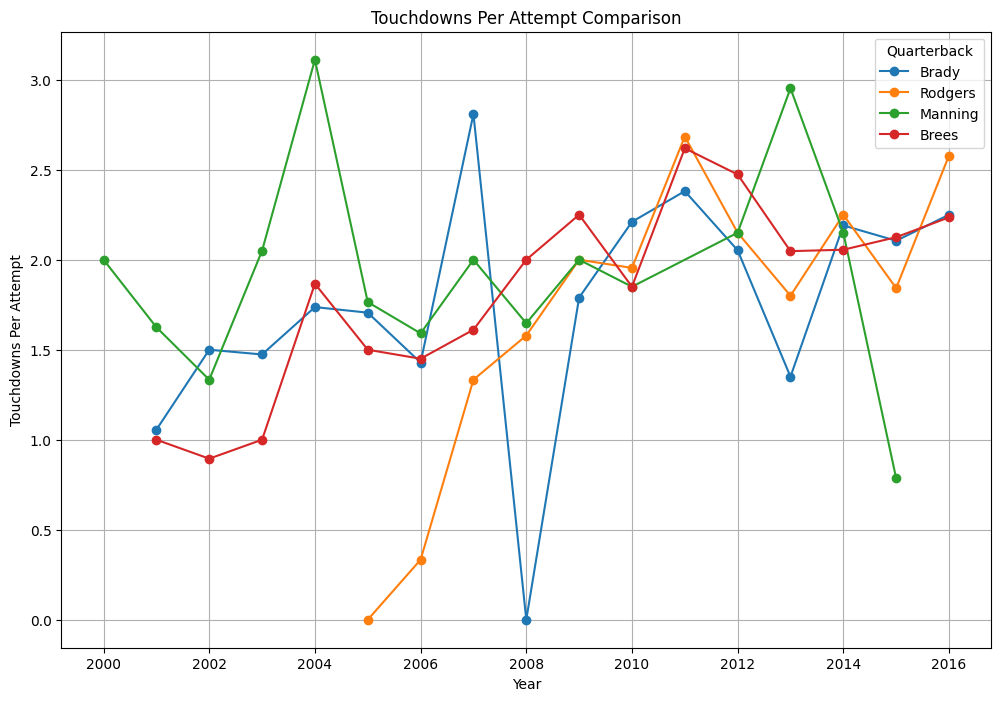

In [39]:
# Plot the touchdowns per game for each season for each of the great QBS
plt.figure(figsize=(12, 8))
for qb in great_qbs:
    qb_stats = great_qbs_df[great_qbs_df['Name'] == qb]
    qb_stats = qb_stats[qb_stats['Total Passes Attempted'] > 0]
    plt.plot(qb_stats['Year'], qb_stats['Total TD Passes'] / qb_stats['Games Played'], marker='o', linestyle='-', label=qb.split(',')[0])

# Add titles and extra information and show
plt.legend(title="Quarterback")
plt.title("Touchdowns Per Attempt Comparison")
plt.ylabel("Touchdowns Per Attempt")
plt.xlabel("Year")
plt.grid()
plt.show()

**Takeaways:** In the chart above, we see that the players aren't seperated by this metric very much.  The leading player varies from season to season.

#### 3.1.5 Interceptions

Interception are incredibly detrimental to a team.  It is a turnover, and it lets the other team go on offense.  It also means that the team who threw the interception doesn't have a chance to score on that drive.

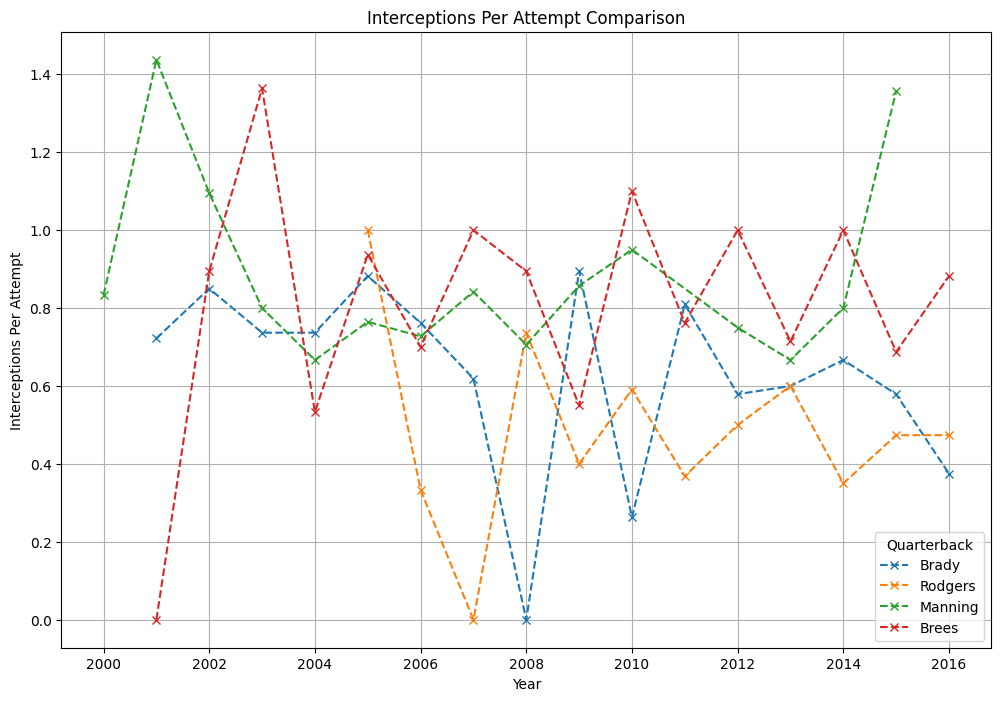

In [40]:
# Plot the interceptions per game for each season for each of the great QBS
plt.figure(figsize=(12, 8))
for qb in great_qbs:
    qb_stats = great_qbs_df[great_qbs_df['Name'] == qb]
    qb_stats = qb_stats[qb_stats['Total Passes Attempted'] > 0]
    plt.plot(qb_stats['Year'], qb_stats['Total Interceptions'] / qb_stats['Games Played'], marker='x', linestyle='--', label=qb.split(',')[0])

# Add titles and extra information and show
plt.legend(title="Quarterback")
plt.title("Interceptions Per Attempt Comparison")
plt.ylabel("Interceptions Per Attempt")
plt.xlabel("Year")
plt.grid()
plt.show()

**Takeaways:** Here we see that Brees and manning were the most careless with the ball.  They threw many interceptions (which is bad) whereas Rodgers threw by far the fewest interceptions per game.  (Although it should be taken into account that they threw more passes as we saw a few graphs ago).  This chart continues to indicate this pattern we've seen with Rodgers that he is much more efficient as a quarterback than the other prospects.  He throws fewer passes, but he throws them for more yards each and with fewer costly turnovers.

#### 3.1.6 Passer Rating

Passer rating is a score developed by the NFL to take into account how wekk a qb did in a game.  It takes into account volume and efficiency as well as several other metrics.

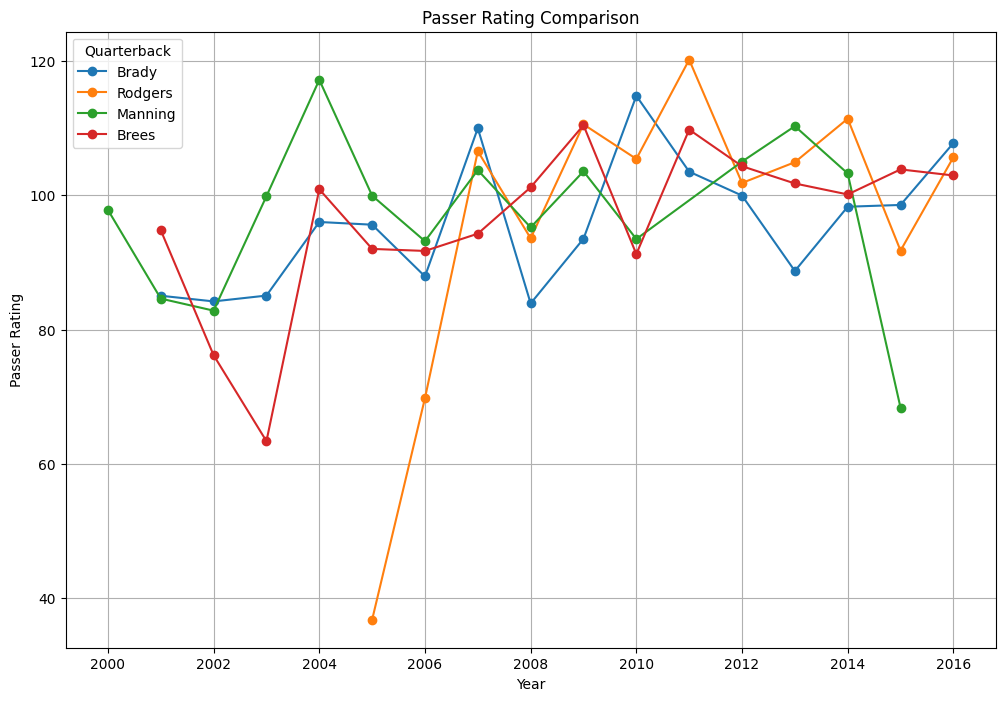

In [41]:
# Plot the average passing rating for each season for each of the great QBS
plt.figure(figsize=(12, 8))
for qb in great_qbs:
    qb_stats = great_qbs_df[great_qbs_df['Name'] == qb]
    plt.plot(qb_stats['Year'], qb_stats['Avg Passer Rating'], marker='o', linestyle='-', label=qb.split(',')[0])

# Add titles and extra information and show
plt.legend(title="Quarterback")
plt.title("Passer Rating Comparison")
plt.ylabel("Passer Rating")
plt.xlabel("Year")
plt.grid()
plt.show()

**Takeaways:** You'll notice in the graph avoce that Rodgers tends to have a higher passer rating.  This is consistent with what we have seen in all of the charts.  While Aaron Rodgers didn't throw for as many yards per game, we can clearly see that each throw he made counted for more in comparison to the other players.  He threw fewer interceptions per attempt and more touchdowns and each completed pass was for more yards.  On the other hand, we see that Brady had an overall lower passer rating which makes sense.

## 3.2 Stats with and without QBs

In this section, we will look to see how playing with a certain quarterback affected the play of the players around them.  We will compare career statistics of different positions with and without the QB in question.  This should indicate to us whether players were performing well because they were playing with a great quarterback or because they themselves are great.  In other words, how does playing with each of our four prospects enhance the play of the key positions around them.

#### 3.2.1 Running Backs

In [42]:
# Create a results dict
results = {}

for qb in great_qbs:
    qb_games = qb_df[qb_df['Name'] == qb][['Year', 'Week', 'Team']]

    # Merge wr data with qb games on Year, Week, and Team
    rb_with_qb = pd.merge(rb_df, qb_games, on=['Year', 'Week', 'Team'], how='inner')
    rb_without_qb = rb_df[~rb_df.index.isin(rb_with_qb.index)]
    rb_with_qb = rb_with_qb.copy()
    rb_without_qb = rb_without_qb.copy()

    # Calculate rushing yards per carry for both groups
    rb_with_qb['Yards Per Carry'] = rb_with_qb['Rushing Yards'] / rb_with_qb['Rushing Attempts']
    rb_without_qb['Yards Per Carry'] = rb_without_qb['Rushing Yards'] / rb_without_qb['Rushing Attempts']

    # Avoid dividing by zero
    rb_with_qb = rb_with_qb[rb_with_qb['Rushing Attempts'] > 0]
    rb_without_qb = rb_without_qb[rb_without_qb['Rushing Attempts'] > 0]

    # Get the average for all the results
    with_qb_avg = rb_with_qb['Yards Per Carry'].mean()
    without_qb_avg = rb_without_qb['Yards Per Carry'].mean()

    # save the result in our dict
    results[qb] = {
        'With QB': round(with_qb_avg, 2),
        'Without QB': round(without_qb_avg, 2)
    }

# Print results
for qb, stats in results.items():
    print(f"{qb}:")
    print(f"  Average Yards Per Carry (with {qb.split(',')[0]}): {stats['With QB']}")
    print(f"  Average Yards Per Carry (without {qb.split(',')[0]}): {stats['Without QB']}\n")

Brady, Tom:
  Average Yards Per Carry (with Brady): 3.9
  Average Yards Per Carry (without Brady): 3.99

Rodgers, Aaron:
  Average Yards Per Carry (with Rodgers): 3.48
  Average Yards Per Carry (without Rodgers): 3.99

Manning, Peyton:
  Average Yards Per Carry (with Manning): 3.89
  Average Yards Per Carry (without Manning): 3.99

Brees, Drew:
  Average Yards Per Carry (with Brees): 4.17
  Average Yards Per Carry (without Brees): 3.98



**Takeaways:** Here, we can see that running backs playing with Drew Brees were much more affective and efficient then when they played without him.  On the other hand, running backs that played with Rodgers ran for much fewer yards when he wasn't playing.  Running backs performed similarly when playing with and without Tom Brady and Peyton Manning.

#### 3.2.2 Receivers

In [43]:
# Create a results dict
wr_results = {}

for qb in great_qbs:
    qb_games = qb_df[qb_df['Name'] == qb][['Year', 'Week', 'Team']]

    # Merge wr data with wb games on Year, Week, and Team
    wr_with_qb = pd.merge(wr_df, qb_games, on=['Year', 'Week', 'Team'], how='inner')
    wr_without_qb = wr_df[~wr_df.index.isin(wr_with_qb.index)]
    wr_with_qb = wr_with_qb.copy()
    wr_without_qb = wr_without_qb.copy()

    # Calculate yards per reception for both groups
    wr_with_qb['Yards Per Reception'] = wr_with_qb['Receiving Yards'] / wr_with_qb['Receptions']
    wr_without_qb['Yards Per Reception'] = wr_without_qb['Receiving Yards'] / wr_without_qb['Receptions']

    # Avoid dividing by zero
    wr_with_qb = wr_with_qb[wr_with_qb['Receptions'] > 0]
    wr_without_qb = wr_without_qb[wr_without_qb['Receptions'] > 0]

    # Get the average for all the results
    with_qb_avg = wr_with_qb['Yards Per Reception'].mean()
    without_qb_avg = wr_without_qb['Yards Per Reception'].mean()

    # save the result in our dict
    wr_results[qb] = {
        'With QB': round(with_qb_avg, 2),
        'Without QB': round(without_qb_avg, 2)
    }

# Print results
for qb, stats in wr_results.items():
    print(f"{qb}:")
    print(f"  Average Yards Per Reception (with {qb.split(',')[0]}): {stats['With QB']}")
    print(f"  Average Yards Per Reception (without {qb.split(',')[0]}): {stats['Without QB']}\n")

Brady, Tom:
  Average Yards Per Reception (with Brady): 12.84
  Average Yards Per Reception (without Brady): 13.18

Rodgers, Aaron:
  Average Yards Per Reception (with Rodgers): 14.51
  Average Yards Per Reception (without Rodgers): 13.19

Manning, Peyton:
  Average Yards Per Reception (with Manning): 13.1
  Average Yards Per Reception (without Manning): 13.18

Brees, Drew:
  Average Yards Per Reception (with Brees): 12.98
  Average Yards Per Reception (without Brees): 13.19



#### 3.2.3 Visualizing

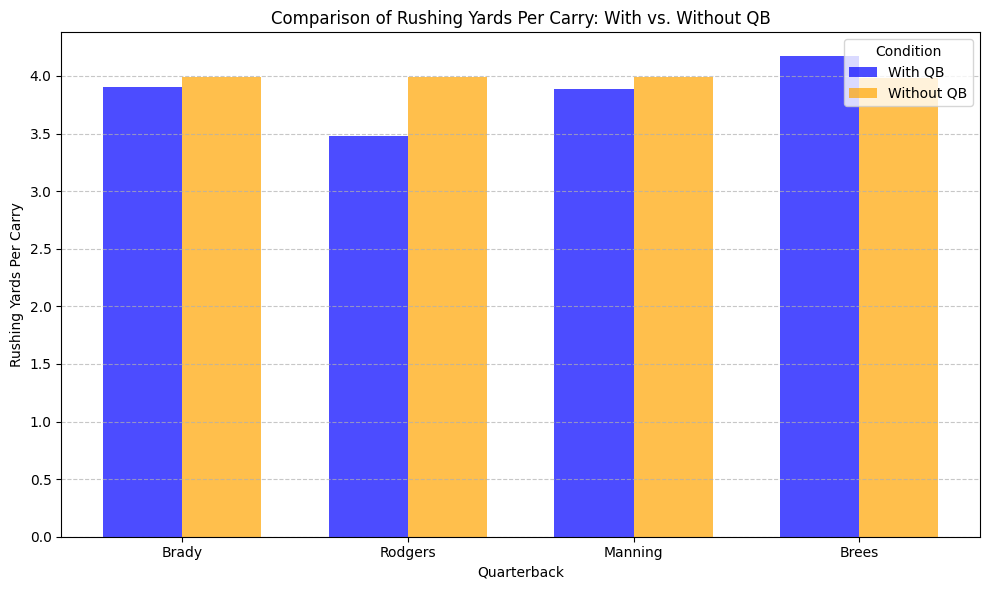

In [44]:
# Shorten QB names for plotting
qb_names = [qb.split(',')[0] for qb in wr_results.keys()]

rb_with_qb = [stats['With QB'] for stats in results.values()]
rb_without_qb = [stats['Without QB'] for stats in results.values()]

# Bar chart settings
x = np.arange(len(qb_names))
width = 0.35

# Bar chart settings for rbs
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rb_with_qb, width, label='With QB', color='blue', alpha=0.7)
plt.bar(x + width/2, rb_without_qb, width, label='Without QB', color='orange', alpha=0.7)

# Do the lables for the charts
plt.legend(title="Condition")
plt.title('Comparison of Rushing Yards Per Carry: With vs. Without QB')
plt.ylabel('Rushing Yards Per Carry')
plt.xlabel('Quarterback')
plt.xticks(x, qb_names)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show chart
plt.tight_layout()
plt.show()


**Takeaways:** The takeaway from this is that running backs seem to play better with Brees, the same with Brady and Manning, and worse with Aaron Rodgers.  Let's thing about why.  If Rodgers' team runs the ball more frequently, as shown earlier, then teams are more likely to protect against the run then the pass.  Therefore, it seems as though Rodgers better efficiency might have just been because teams are guarding the run more than the pass when defending him.  Furthermore, this would imply that Rodgers amazing efficiency metrics are a biprodct of his team's system.  Brees, on the other hand, threw more passes, but less well.  This is also consistent with the theory that when a team throws the ball fewer times, the quarterback will have better efficiency metrics like Rodgers does.

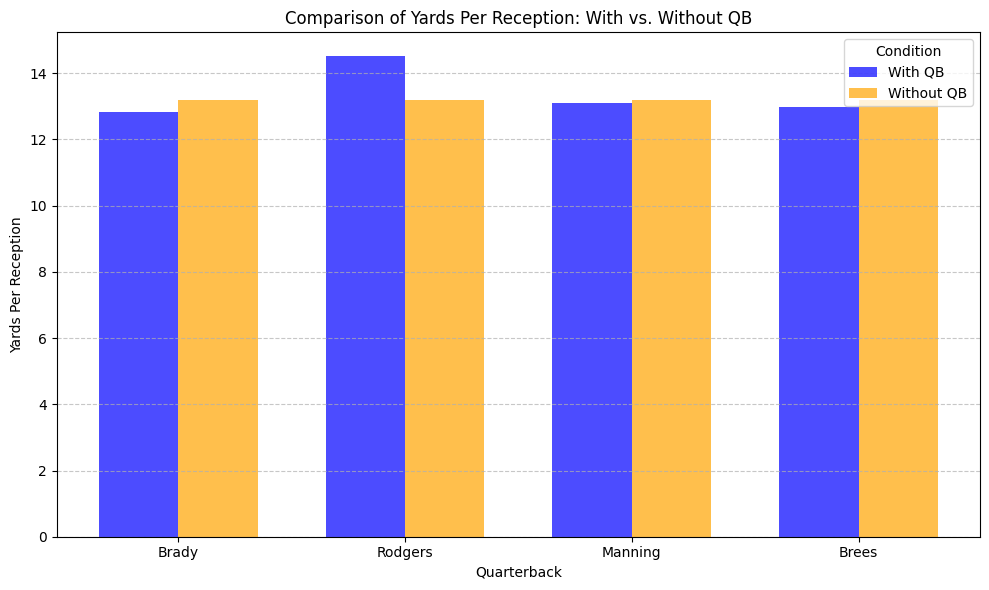

In [45]:
# Shorten QB names for plotting
qb_names = [qb.split(',')[0] for qb in wr_results.keys()]

with_qb = [stats['With QB'] for stats in wr_results.values()]
without_qb = [stats['Without QB'] for stats in wr_results.values()]

# Bar chart settings for wrs
x = np.arange(len(qb_names))
width = 0.35

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, with_qb, width, label='With QB', color='blue', alpha=0.7)
plt.bar(x + width/2, without_qb, width, label='Without QB', color='orange', alpha=0.7)

# Do the lables for the charts
plt.legend(title="Condition")
plt.title('Comparison of Yards Per Reception: With vs. Without QB')
plt.ylabel('Yards Per Reception')
plt.xlabel('Quarterback')
plt.xticks(x, qb_names)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show chart
plt.tight_layout()
plt.show()


**Takeaways:** What we see here is completely unsurprising and consistent with our past observations.  We see that Rodgers' receivers are getting more yards per reception.  As we've seen, Rodgers' team tends to run the ball more than other teams. This would mean that the teams who are defending them are trying to defend the run more than they are trying to defend a pass, at least in comparison with the other quarterbacks that we've looked at.  Therefore, we come to the conclusion that the Packers, Rodgers' team, were just better set up for receivers in the quarterback to be more efficient and to get more yards per passing play because teams were trying to defend the run against them.  

## 3.3 Feature Correlation Heatmap

#### 3.3.1 Mergine Player DFs

In this section, we want to find out which team statistics are too closely corrilated to the QB stats to be included in our models. So what we will do here is start by merging the qb, rb, wr and kicker stats into 1 dataframe where each row is a game.

In [46]:
# Drop player name columns from each dataframe
qb_df_n = qb_df.drop(columns=['Name'])
rb_team_df_n = rb_team_df.drop(columns=['Players Involved'])
wr_team_df_n = wr_team_df.drop(columns=['Players Involved'])
k_df_n = k_df.drop(columns=['Name'])

# Merge QB data with RB team data
games_df = pd.merge(qb_df_n, rb_team_df_n, how='inner', on=['Year', 'Week', 'Game Date', 'Team', 'Opponent Score', 'Team Score', 'Outcome'])

# Merge the result with WR team data
games_df = pd.merge(games_df, wr_team_df_n, how='inner', on=['Year', 'Week', 'Game Date', 'Team', 'Opponent Score', 'Team Score', 'Outcome'])

# Merge the result with Kicker data
games_df = pd.merge(games_df, k_df_n, how='inner', on=['Year', 'Week', 'Game Date', 'Team', 'Opponent Score', 'Team Score', 'Outcome'])

# Remove rows with null values
games_df = games_df.dropna()

# Reset index to clean up the dataframe
games_df = games_df.reset_index(drop=True)

# Show the resulting dataframe
print(games_df.columns)
games_df

Index(['Year', 'Week', 'Game Date', 'Outcome', 'Passes Completed',
       'Passes Attempted', 'Completion Percentage', 'Passing Yards',
       'Passing Yards Per Attempt', 'TD Passes', 'Ints', 'Passer Rating',
       'Team Score', 'Opponent Score', 'Team', 'Total Rushing Attempts',
       'Total Rushing Yards', 'Avg Yards Per Carry', 'Total Rushing TDs',
       'Total Receptions', 'Total Receiving Yards', 'Avg Yards Per Reception',
       'Total Receiving TDs', 'FGs Attempted', 'FGs Made', 'FG Percentage',
       'Extra Points Made', 'Extra Points Attempted',
       'Percentage of Extra Points Made'],
      dtype='object')


,Year,Week,Game Date,Outcome,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,...,Total Receptions,Total Receiving Yards,Avg Yards Per Reception,Total Receiving TDs,FGs Attempted,FGs Made,FG Percentage,Extra Points Made,Extra Points Attempted,Percentage of Extra Points Made
0,2007,5,2007-10-07,W,20,27,74.1,218,8.1,1,...,4,73,18.250000,1,2,1,50.0,2,2,100.0
1,2007,6,2007-10-14,W,22,34,64.7,221,6.5,2,...,4,46,11.500000,0,2,1,50.0,4,5,80.0
2,2007,7,2007-10-22,L,8,12,66.7,72,6.0,0,...,3,20,6.666667,0,0,0,0.0,1,1,100.0
3,2007,11,2007-11-18,W,15,24,62.5,189,7.9,2,...,3,36,12.000000,0,0,0,0.0,0,0,0.0
4,2009,1,2009-08-13,L,6,10,60.0,53,5.3,0,...,17,200,11.764706,1,1,1,100.0,1,1,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2015,14,2015-12-13,L,35,51,68.6,308,6.0,0,...,20,191,9.550000,0,5,4,80.0,0,0,0.0
908,2015,15,2015-12-20,L,21,44,47.7,296,6.7,3,...,18,276,15.333333,3,0,0,0.0,3,4,75.0
909,2015,16,2015-12-28,W,27,39,69.2,299,7.7,1,...,16,171,10.687500,1,3,2,66.7,2,2,100.0
910,2015,17,2015-01-03,W,14,22,63.6,232,10.5,1,...,14,278,19.857143,1,2,2,100.0,3,3,100.0


#### 3.3.2 Heatmap

Now we will finally make out heatmap to see which features are most closely corrilated

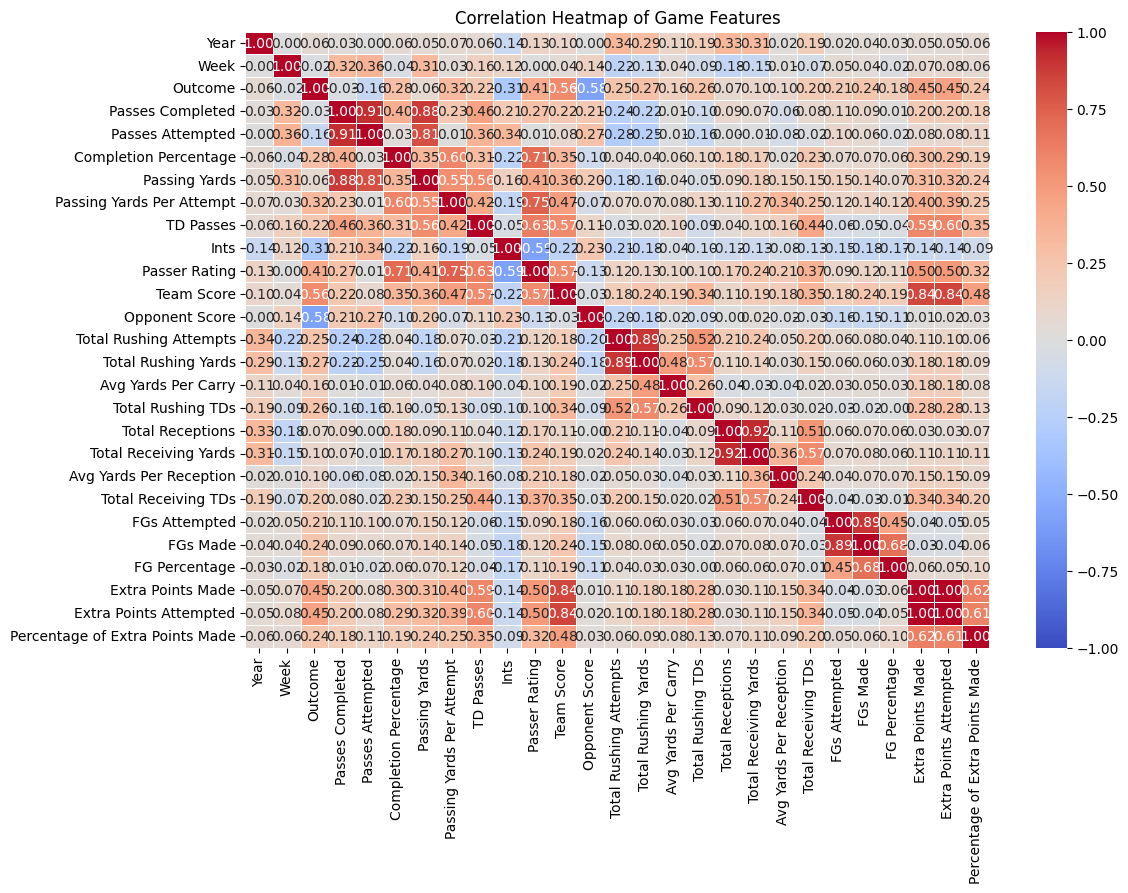

In [47]:
# Convert Outcome to be numeric values (0 or 1 for loss or win)
games_df['Outcome'] = games_df['Outcome'].map({'W': 1, 'L': 0})

# Drop non-numeric columns
games_df_numeric = games_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = games_df_numeric.corr()

# Generate the new heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)

# Make title and display
plt.title('Correlation Heatmap of Game Features')
plt.show()

**Takeaways:** As we can see in the Heat map, there are many features that are correlated with QB statistics.  For example, of course, we see that receiving yards and receiving touchdowns and total receptions are all heavily correlated with quarterback statistics. This makes perfect sense because each time a quarterback throws, it means that someone on their team is being targeted and will or won't catch the ball if the quarterback does or does not have a reception added to their list.  Likewise, receiving touchdowns are heavily correlated with throwing touchdowns.  We notice that many of the kicker statistics are correlated with QB statistics.  For example, extra points made and extra points attempted are heavily correlated with throwing touchdowns.  Additionally, we see that field goals attempted are also correlated with throwing yards because if a quarterback throws for more yards, it means that they are in good field goal position for the kicker to make a kick. However, the percentages of field goals made and extra points made are not correlated with the QB statistics presented.  Therefore, we will remove all of the QB related statistics in the next step when we try to see if the quarterback and quarterback related statistics are important in predicting the result of a game.

# Part 4: Feature Engineering & Preprocessing

## 4.1 Removing Features Correlated with QB stats

#### 4.1.1 Removing Unnessissary Columns

What we want to do here is remove any of the columns that wont make sense. the columsn we will remove aare these

In [48]:
# Drop arbitrary columns that don't matter for the game
games_df = games_df.drop(columns=['Year', 'Week', 'Game Date', 'Team'])

# Drop nulls
games_df.dropna(inplace=True)

# Show
games_df.head()

,Outcome,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Ints,Passer Rating,Team Score,...,Total Receptions,Total Receiving Yards,Avg Yards Per Reception,Total Receiving TDs,FGs Attempted,FGs Made,FG Percentage,Extra Points Made,Extra Points Attempted,Percentage of Extra Points Made
0,1.0,20,27,74.1,218,8.1,1,0,109.8,17,...,4,73,18.250000,1,2,1,50.0,2,2,100.0
1,1.0,22,34,64.7,221,6.5,2,0,102.7,37,...,4,46,11.500000,0,2,1,50.0,4,5,80.0
2,0.0,8,12,66.7,72,6.0,0,0,82.6,7,...,3,20,6.666667,0,0,0,0.0,1,1,100.0
3,1.0,15,24,62.5,189,7.9,2,0,114.8,24,...,3,36,12.000000,0,0,0,0.0,0,0,0.0
4,0.0,6,10,60.0,53,5.3,0,0,74.2,10,...,17,200,11.764706,1,1,1,100.0,1,1,100.0


#### 4.1.2 Set up games_df without QB stats

What we want to do here is drop all QB columns and QB related columns

In [49]:
# Drop QB-stat related columns
games_df_noqb = games_df.drop(columns=['Passes Completed', 'Passes Attempted', 'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt', 'TD Passes', 'Ints', 'Passer Rating', 'Extra Points Made', 'Extra Points Attempted', 'FGs Attempted', 'FGs Made'])
games_df_noqb.head()

,Outcome,Team Score,Opponent Score,Total Rushing Attempts,Total Rushing Yards,Avg Yards Per Carry,Total Rushing TDs,Total Receptions,Total Receiving Yards,Avg Yards Per Reception,Total Receiving TDs,FG Percentage,Percentage of Extra Points Made
0,1.0,17,7,16,51,3.187500,0,4,73,18.250000,1,50.0,100.0
1,1.0,37,17,6,90,15.000000,0,4,46,11.500000,0,50.0,80.0
2,0.0,7,29,11,55,5.000000,0,3,20,6.666667,0,0.0,100.0
3,1.0,24,17,20,85,4.250000,0,3,36,12.000000,0,0.0,0.0
4,0.0,10,20,21,68,3.238095,0,17,200,11.764706,1,100.0,100.0


## 4.2 PCA

Lets run our PCA

In [50]:
# Select features and target from games and games without the qb stats included
X = games_df.drop(columns=['Outcome', 'Team Score'])
X_noqb = games_df_noqb.drop(columns=['Outcome', 'Team Score'])
y = games_df['Outcome']
y_noqb = games_df_noqb['Outcome']

# Standardize the data with Standard Scaler (imported at the top of the project)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_noqb_scaled = scaler.fit_transform(X_noqb)

# Run PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_noqb_pca = pca.fit_transform(X_noqb_scaled)

## 4.3 Train/Test Data Split

Split the data into training and testing data

In [51]:
# Split training and testing data for with and without QB stats
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_noqb_train, X_noqb_test, y_noqb_train, y_noqb_test = train_test_split(X_noqb_pca, y_noqb, test_size=0.3, random_state=42)

# Part 5: Modeling

## 5.1 Logistic Regression

We're going to start by running logistic regression on our games df with and without the QB and QB-related data.  The goal is to give a sense how important this QB data is to the outcome of the game.

In [52]:
# Train the logistic regression model for all data (inlcuding QB)
model_logistic_regression = LogisticRegression()
model_logistic_regression.fit(X_train, y_train)

# Make predictions
y_pred = model_logistic_regression.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


In [53]:
# Train the logistic regression model for non-QB data
model_logistic_regression_noqb = LogisticRegression()
model_logistic_regression_noqb.fit(X_noqb_train, y_noqb_train)

# Make predictions
y_pred = model_logistic_regression_noqb.predict(X_noqb_test)

# Evaluate the model
accuracy = accuracy_score(y_noqb_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


We get the following results:

1.   Accuracy with all data: 91%
2.   Accuracy without QB data: 82%

From this we see that our model benefits greatly from the use of QB data.  We are able to predict if a team wins a game using results of the quarterback.  However, it should be noted that the difference was significant but not astronomical.  The model to predict wins without QB related data is still relatively accurate.

While it is not possible to quantify that Quarterbacks have "a 9% more important impact then the rest," it is important to see how important the position is.



## 5.2 Linear Regression

In this section, we will use a similar process to predict how many points a team will score in a game.  We will then analyze how useful the QB data is in predicting the points scored for their team

In [54]:
# Select features and target variable
X = games_df.drop(columns=['Outcome', 'Team Score'])
y = games_df['Team Score']
X_noqb = games_df_noqb.drop(columns=['Outcome', 'Team Score'])
y_noqb = games_df_noqb['Team Score']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_noqb_scaled = scaler.fit_transform(X_noqb)

# Optional: Apply PCA (if needed, to reduce dimensionality)
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_scaled)
X_noqb_pca = pca.fit_transform(X_noqb_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_noqb_train, X_noqb_test, y_noqb_train, y_noqb_test = train_test_split(X_noqb_pca, y_noqb, test_size=0.3, random_state=42)

# Train the regression model (Linear Regression, Ridge, or Lasso)
model = LinearRegression()
model.fit(X_train, y_train)
model_noqb = LinearRegression()
model_noqb.fit(X_noqb_train, y_noqb_train)

# Make predictions
y_pred = model.predict(X_test)
y_noqb_pred = model_noqb.predict(X_noqb_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse_noqb = mean_squared_error(y_noqb_test, y_noqb_pred)
r2_noqb = r2_score(y_noqb_test, y_noqb_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error (no QB): {mse_noqb:.2f}")
print(f"R-squared (no QB): {r2_noqb:.2f}")


Mean Squared Error: 20.23
R-squared: 0.80
Mean Squared Error (no QB): 65.45
R-squared (no QB): 0.35


The results are as follows:

1.   **Mean Squared Error: 20.23**
2.   **R-squared: 0.80**
3.   **Mean Squared Error (no QB): 65.45**
4.   **R-squared (no QB): 0.35**

Our results here are easy to interpret.  When we try to predict points scored using all of the QB data in addition to the other data, we can be very accurate in predicting points.  However, by taking away that QB data, we have a much worse model.  This shows even more so how important QB data is when computing the success of an offense.

This has a larger discrepency between the data sets then the logistic regression model because that model was only predicing wins and losses.  Therefore, the number of points scored by the defense was very helpful in that.  This measures pure offensive success.  Of course, there can be some varience to the data.  For example, if a team gets a interception that they return for a touchdown (also known as a "pick-6"), that would be the defense scoring while the offense isn't even on the field.  Likewise, if a kick returner or punt returner returns a kick or punt for a touchdown, that would be another example of a team scoring without the quarterback on the field.  However, because these events are so rare, our model would likely show neglegable difference with it included.

## 5.3 Neural Networks

In [55]:
 # Prep the data
X = games_df.drop(columns=['Team Score', 'Outcome'])
y_score = games_df['Team Score']
y_outcome = games_df['Outcome']

# Split data into training and test sets
X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.2, random_state=42)
X_train, X_test, y_train_outcome, y_test_outcome = train_test_split(X, y_outcome, test_size=0.2, random_state=42)

#################### Neural Network for Score Prediction (Regression) ##############################
score_model = models.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

score_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
score_model.fit(X_train, y_train_score, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate model
score_model.evaluate(X_test, y_test_score)

#################### Neural Network for Win/Loss Prediction (Classification) ##############################
outcome_model = models.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

outcome_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
outcome_model.fit(X_train, y_train_outcome, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate model
outcome_model.evaluate(X_test, y_test_outcome)

#################### Make Predictions ##############################
predicted_scores = score_model.predict(X_test)
predicted_outcomes = (outcome_model.predict(X_test) > 0.5).astype(int)
score_loss = score_model.evaluate(X_test, y_test_score)
outcome_loss, outcome_accuracy = outcome_model.evaluate(X_test, y_test_outcome)

print(f"Score Prediction Model - Loss: {score_loss}")
print(f"Win/Loss Prediction Model - Loss: {outcome_loss}")
print(f"Win/Loss Prediction Model - Accuracy: {outcome_accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1369.5693 - val_loss: 164.7569
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 101.0450 - val_loss: 65.8973
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.8643 - val_loss: 63.5538
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.5670 - val_loss: 60.1282
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.3077 - val_loss: 58.2027
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 51.7185 - val_loss: 56.2979
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.8825 - val_loss: 54.8779
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.6109 - val_loss: 54.6643
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.9297 - val_loss: 53.3119
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.5668 - val_loss: 52.9798
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.5512 - val_loss: 54.9972
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4693 - loss: 2.9256 - val_accuracy: 0.6096 - val_loss: 1.1331
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6202 - loss: 1.1657 - val_accuracy: 0.7329 - val_loss: 0.6740
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - loss: 0.9276 - val_accuracy: 0.7123 - val_loss: 0.6907
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7135 - loss: 0.7463 - val_accuracy: 0.7671 - val_loss: 0.6038
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7330 - loss: 0.6890 - val_accuracy: 0.7945 - val_loss: 0.4803
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7979 - loss: 0.4568 - val_accuracy: 0.8288 - val_loss: 0.4405
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8111 - loss: 0.4466 - val_accuracy: 0.8219 - val_loss: 0.3751
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8235 - loss: 0.4644 - val_accuracy: 0.8014 - val_loss: 0.3713
Ep

In [56]:
 # Prepare your data (for example)
X = games_df_noqb.drop(columns=['Team Score', 'Outcome'])
y_score = games_df_noqb['Team Score']
y_outcome = games_df_noqb['Outcome']

# Split data into training and test sets
X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.2, random_state=42)
X_train, X_test, y_train_outcome, y_test_outcome = train_test_split(X, y_outcome, test_size=0.2, random_state=42)

#################### Neural Network for Score Prediction (Regression) ##############################
score_model_noqb = models.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

score_model_noqb.compile(optimizer='adam', loss='mean_squared_error')

# Train model
score_model_noqb.fit(X_train, y_train_score, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate model
score_model_noqb.evaluate(X_test, y_test_score)

#################### Neural Network for Win/Loss Prediction (Classification) ##############################
outcome_model_noqb = models.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

outcome_model_noqb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
outcome_model_noqb.fit(X_train, y_train_outcome, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate model
outcome_model_noqb.evaluate(X_test, y_test_outcome)

#################### Make Predictions ##############################
predicted_scores = score_model_noqb.predict(X_test)
predicted_outcomes = (outcome_model_noqb.predict(X_test) > 0.5).astype(int)
score_loss = score_model_noqb.evaluate(X_test, y_test_score)
outcome_loss, outcome_accuracy = outcome_model_noqb.evaluate(X_test, y_test_outcome)

print(f"Score Prediction Model - Loss (no qb): {score_loss}")
print(f"Win/Loss Prediction Model - Loss (no qb): {outcome_loss}")
print(f"Win/Loss Prediction Model - Accuracy (no qb): {outcome_accuracy}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 214.0483 - val_loss: 111.1076
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 98.2045 - val_loss: 83.6500
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 82.5409 - val_loss: 81.6601
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 75.1402 - val_loss: 75.8600
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 69.5167 - val_loss: 73.5944
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 67.2728 - val_loss: 74.5458
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 71.2042 - val_loss: 73.8905
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.1258 - val_loss: 75.3089
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.4532 - val_loss: 74.7366
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.7237 - val_loss: 74.6977
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67.7268 - val_loss: 74.9700
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4805 - loss: 5.2009 - val_accuracy: 0.4795 - val_loss: 1.7160
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4937 - loss: 1.3387 - val_accuracy: 0.6164 - val_loss: 1.0484
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6706 - loss: 0.6864 - val_accuracy: 0.6644 - val_loss: 0.6874
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7403 - loss: 0.5508 - val_accuracy: 0.7397 - val_loss: 0.5303
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7541 - loss: 0.5170 - val_accuracy: 0.7123 - val_loss: 0.5223
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7797 - loss: 0.4684 - val_accuracy: 0.7466 - val_loss: 0.5062
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 0.4325 - val_accuracy: 0.7534 - val_loss: 0.5565
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7557 - loss: 0.5052 - val_accuracy: 0.7466 - val_loss: 0.5329
Ep

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.3357  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8013 - loss: 0.5197 
Score Prediction Model - Loss (no qb): 66.16834259033203
Win/Loss Prediction Model - Loss (no qb): 0.49482372403144836
Win/Loss Prediction Model - Accuracy (no qb): 0.7978141903877258


THe results are as follows:

With QB data:
1.   Score Prediction Model - Loss: 40.293277740478516
2.   Win/Loss Prediction Model - Loss: 0.317948579788208
3.   Win/Loss Prediction Model - Accuracy: 0.8524590134620667

Without QB data:
1.   Score Prediction Model - Loss (no qb): 68.11263275146484
2.   Win/Loss Prediction Model - Loss (no qb): 0.5710017085075378
3.   Win/Loss Prediction Model - Accuracy (no qb): 0.7759562730789185

Once again, the results stay consistent.  There is a marginal, if not significant, difference between the the two models.  We can clearly see that the neural network works much better with the QB data inputted.

# Part 6: Conclusion

**Here are the main takeaways:**


*   Win percentage is a Quarterback statistic.  QB play is very important in predicting if a team is going to win or lose.  We saw that with every type of model we tried, predicting points or a win/loss, including QB stats in the calculation made it much easier.
*   Tom Brady has the highest win percentage of any of the great QBs we concidered throughout the project.  However, it wasn't clear from our tests that QB data is the only way to tell who is the best quarterback.  In fact, in our EDA, we discovered that Tom Brady actually appeared to be the worst of the four quarterbacks concidered, while Aaron Rodgers was concidered to be the best.  Thus, the mystery of who is the greatest quarterback of all time remains.  It is up to the individual to concider which stats are most important when making this decision.  Some people like to use the "eye test" to decide who is the best.  In other words, some people say that the only way to know who the greatest is, it to watch the greats play.
*   In conclusion, wins reflects a quarterback's ability, but Tom Brady leaves room to be desired in terms of counting stats.  Therefore, it remains ambigious who is the NFL GOAT.

**In the future, the following modifications would be nice:**
*   For a future project, it would be nice to concider more recent data.  The dataset I used only had data available through 2016 and since then, many new contenders for the GOAT QB have emerged such as Lamar Jackson or Patrick Mahomes.
*   Additionally, ian improvement for this project might be to concider only the years playing right before or after a quarterback for the EDA since rookies and old players tend to play worse.  Especially, using a bell curve mapped to career performance averages for each position would reflect more accurately the difference in player stats with and without elite quarterbacks.
*   For the modeling part of the assingment, given more time it would be nice to try out more variations on columns to input.  For example, what if much fewer columns were used and 0 counting stats were involved?  Then we would only use percentages as our inputs.  Stats like field goal percentage, completion percentage and yards per attempt would be included.  Total yards and stats like that would not.  This might give us a better sense of how truly important a quarterback is on each individual play.  Then we could try removing wide reciever stats and running back stats to try to put some quantifier on the importance of each and every position.



**Overall expierience/reflection:**

It was very exciting to get to put my newfound AI, ML and Big Data expierience to work.  This was a great learning expierence trying to do a project by myself.  I worked alone on this which wasn't super fun, but it meant that I got to work on a project that I was really interested and passionate about.  Additionally, working on a project where the statistics were meaningful to me was a plus instead of looking at arbitrary numbers.